## Basical settings

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder
import multiprocessing
import time
import torch

/home/yl127/anaconda3/envs/astrodet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi
print(torch.__version__)
print(torch.cuda.is_available())

No devices were found
1.10.1
False


Global variables

In [3]:
wavelengths     = np.arange(400, 800)*u.nm
FWHM            = 0.5
lambda_Na       = 589.0*u.nm
lambda_Mg       = 518.3*u.nm
width           = 1000
height          = 1500

dir='./dataset/'
os.makedirs(dir, exist_ok=True)

## Generate dataset

Define the function to generate the image. 

In [4]:
def add_background(image_3d):
    '''
    '''
    # TODO: mutate the background
    for i in range(400):
        image_3d[:,:,i] += int(30-0.06*i)
    return image_3d

def add_stars(image_3d, coord_stars, amp_stars, T_stars): 
    '''
    '''
    # psf
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    # draw N stars with radius FWHM/2
    for [x, y], amp_star, T_star in zip(coord_stars, amp_stars, T_stars): 
        # spectrum
        BB = models.BlackBody(temperature=T_star)
        # add star to the image
        radius = int(5*FWHM)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*BB(wavelengths).value*amp_star
        star = star.astype('uint16')
        image_3d[x-radius:x+radius+1,y-radius:y+radius+1,:] += star
    return image_3d

def add_meteor(image_3d, coord_meteors, amp_meteors, T_meteors, dir_meteors, length_meteors): 
    '''
    '''
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    for [x, y], amp_meteor, T_meteor, dir_meteor, length_meteor in zip(coord_meteors, amp_meteors, T_meteors, dir_meteors, length_meteors):
        # spectrum - continuous spectrum
        BB = models.BlackBody(temperature=T_meteor)
        meteor_x = BB(wavelengths).value*amp_meteor
        # spectrum - emission line
        amp_Na = amp_meteor*2e-6
        amp_Mg = amp_meteor*1e-6
        emission_Na = functional_models.Gaussian1D(mean=lambda_Na.value, stddev=FWHM)
        emission_Mg = functional_models.Gaussian1D(mean=lambda_Mg.value, stddev=FWHM)
        meteor_x += emission_Na(wavelengths.value)*amp_Na
        meteor_x += emission_Mg(wavelengths.value)*amp_Mg
        # trajectory
        meteor_y = np.arange(length_meteor)
        amplitude = 1e3
        # TODO: use true trajectory
        meteor_y = (meteor_y*10/length_meteor)**(0.1) - meteor_y/length_meteor
        meteor_y = meteor_y*amplitude
        meteor = np.outer(meteor_y, meteor_x)
        # draw meteor
        dx = np.cos(dir_meteor)
        dy = np.sin(dir_meteor)
        for i in range(length_meteor): 
            radius = int(5*FWHM)
            x_plot = int(x + dx*i)
            y_plot = int(y + dy*i)
            xx = np.arange(-radius, radius+1)
            yy = np.arange(-radius, radius+1)
            XX, YY = np.meshgrid(xx, yy)
            star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*meteor[i, :]
            star = star.astype('uint16')
            image_3d[x_plot-radius:x_plot+radius+1,y_plot-radius:y_plot+radius+1,:] += star
    # plt.imshow(meteor)
    # plt.colorbar()
    # plt.show()


    # TODO: return the bounding box
    return image_3d

def add_landscape(image_3d): 
    '''
    TODO
    '''
    return image_3d

def capture(image_3d, direction, length): 
    '''
    '''
    dx = np.cos(direction)
    dy = np.sin(direction)
    for i in range(400): 
        # print(i, int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=0, shift=int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=1, shift=int(dy*length*i/400))
    image_rgb = np.zeros([width, height, 3], dtype=np.uint16)
    # RGB filter
    # TODO: adjust the RGB curve of camera
    # TODO: adjust the true slit distortion
    gaussian_r = functional_models.Gaussian1D(mean=600, stddev=30)
    gaussian_g = functional_models.Gaussian1D(mean=540, stddev=30)
    gaussian_b = functional_models.Gaussian1D(mean=480, stddev=30)
    filter_r = gaussian_r(wavelengths.value)
    filter_g = gaussian_g(wavelengths.value)
    filter_b = gaussian_b(wavelengths.value)
    filter_r[200:400] = 1-np.arange(200)**2/200**2
    # generate RGB components
    image_rgb[:, :, 0] = np.average(image_3d*filter_r, axis=2)
    image_rgb[:, :, 1] = np.average(image_3d*filter_g, axis=2)
    image_rgb[:, :, 2] = np.average(image_3d*filter_b, axis=2)
    image_rgb = image_rgb.astype('uint16')
    return image_rgb

def augmentation(image_rgb): 
    '''
    Add the lens effect such as disortion and gaussian noise
    TODO: use `imgaug`
    '''
    return image_rgb


def generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                    angle_meteor, length_meteor, angle_slit, length_slit): 
    '''
    function to generate the image. 
    Args: 
        The position of all the stars, the meteor, etc.: 
        coords_stars    [N, 2]      the coordinates of stars plotted in the diagram. Will also give the number of stars
        TODO...
        angle_slit      [0, 2pi)
        angle_meteor    [0, 2pi)
        length_meteor   int         how long the meteor is 
        length_slit     int         how long the track of spectrum is
    Return: 
        one RGB image
    '''
    image_3d = np.zeros([width, height, 400], dtype=np.uint16)           # 0-65536, valid in 0-256 TODO: change to float16? 
    image_3d = add_background(image_3d)
    image_3d = add_stars(image_3d, coord_stars, amp_stars, T_stars)
    image_3d = add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, angle_meteor, length_meteor)
    image_rgb = capture(image_3d, angle_slit, length_slit)
    image_rgb = augmentation(image_rgb)
    # clip the image
    image_rgb = np.clip(image_rgb, 0, 255)# including 0 and 255
    # image_rgb = image_rgb.astype('uint8')
    return image_rgb #image_3d[:,:,0]
    


In [19]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    # TODO: if exception
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    anno_id_start = 1# max([i['id'] for i in labels['annotations']]) + 1
    anno_id = anno_id_start
    image_id_start = 1# max([i['id'] for i in labels['images']]) + 1
    # Loop to generate images
    for image_id in range(image_id_start, image_id_start + num_images): 
        filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
        print('generating image: %s...'%filename)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        num_meteors     = 20
        length_meteors  = (np.random.rand(num_meteors)*500).astype(np.int16)                      # pixel
        x_meteors       = (np.random.rand(num_meteors)*(width-2*length_meteors)+length_meteors).astype(np.int16)
        y_meteors       = (np.random.rand(num_meteors)*(height-2*length_meteors)+length_meteors).astype(np.int16)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteors   = np.array([x_meteors, y_meteors]).T        # [n, 2]pixel
        amp_meteors     = np.random.rand(num_meteors)*1e8           # [n]erg -> pixel value
        T_meteors       = [2000*u.K]*num_meteors                    # [n]5000K-20000K
        angle_meteors   = np.random.rand(num_meteors)*2*np.pi       # [n]radian
#         length_meteors
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # image
        image = generate_image(coord_stars, amp_stars, T_stars, coord_meteors, amp_meteors, T_meteors, 
                                angle_meteors, length_meteors, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, filename), quality=100)
        # label - image
        label_image = {
            'license': 1,
            'file_name': filename,
            'height': width,
            'width': height,
            'id': image_id
        }
        labels['images'].append(label_image)
        # label - annotation - meteor
        for [x_meteor, y_meteor], angle_meteor, length_meteor in zip(coord_meteors, angle_meteors, length_meteors):
            bbox_x1      = int(min(
                x_meteor, 
                x_meteor + np.cos(angle_slit)*length_slit, 
                x_meteor + np.cos(angle_meteor)*length_meteor, 
                x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
            ))
            bbox_y1      = int(min(
                y_meteor, 
                y_meteor + np.sin(angle_slit)*length_slit, 
                y_meteor + np.sin(angle_meteor)*length_meteor, 
                y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
            ))
            bbox_x2      = int(max(
                x_meteor, 
                x_meteor + np.cos(angle_slit)*length_slit, 
                x_meteor + np.cos(angle_meteor)*length_meteor, 
                x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
            ))
            bbox_y2      = int(max(
                y_meteor, 
                y_meteor + np.sin(angle_slit)*length_slit, 
                y_meteor + np.sin(angle_meteor)*length_meteor, 
                y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
            ))
            bbox_w      = bbox_x2 - bbox_x1
            bbox_h      = bbox_y2 - bbox_y1
            start_Na_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Na.value-400)/400)
            start_Na_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Na.value-400)/400)
            end_Na_x    = int(start_Na_x + np.cos(angle_meteor)*length_meteor)
            end_Na_y    = int(start_Na_y + np.sin(angle_meteor)*length_meteor)
            start_Mg_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
            start_Mg_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
            end_Mg_x    = int(start_Mg_x + np.cos(angle_meteor)*length_meteor)
            end_Mg_y    = int(start_Mg_y + np.sin(angle_meteor)*length_meteor)
            label_meteor = {
                'id': anno_id, 
                'image_id': image_id,
                'category_id': 1,
                'bbox': [
                    bbox_y1, bbox_x1, bbox_h, bbox_w
                ],
                'keypoints': [
                    start_Na_y, start_Na_x, 2, end_Na_y, end_Na_x, 2, 
                    start_Mg_y, start_Mg_x, 2, end_Mg_y, end_Mg_x, 2
                ], 
                'num_keypoints': 4
            }
            labels['annotations'].append(label_meteor)
            anno_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            start_star_x    = x
            start_star_y    = y
            end_star_x      = int(x + np.cos(angle_slit)*length_slit)
            end_star_y      = int(y + np.sin(angle_slit)*length_slit)
            bbox_x1 = min(start_star_x, end_star_x)
            bbox_y1 = min(start_star_y, end_star_y)
            bbox_x2 = max(start_star_x, end_star_x)
            bbox_y2 = max(start_star_y, end_star_y)
            bbox_w      = bbox_x2 - bbox_x1
            bbox_h      = bbox_y2 - bbox_y1
            # check if the star is valid for labelling
            if 0<=end_star_x and end_star_x<width and 0<=end_star_y and end_star_y<height: 
                label_star = {
                    'id': anno_id, 
                    'image_id': image_id,
                    'category_id': 2,
                    'bbox': [
                        bbox_y1, bbox_x1, bbox_h, bbox_w
                    ],
                    'keypoints': [
                        start_star_y, start_star_x, 2, end_star_y, end_star_x, 2, 0, 0, 0, 0, 0, 0
                    ], 
                    'num_keypoints': 2
                }
                labels['annotations'].append(label_star)
                anno_id += 1
        # rewrite json file everytime finishing generating an image
        with open(os.path.join(dir, 'labels.json'), 'w') as f:
            json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels


Generate the dataset. 

In [ ]:
labels = {
    'info': {
        'description': 'Meteor spectrum fake data',
        'url': 'https://cheysen.fit',
        'version': '0.1',
        'year': 2023,
        'contributor': 'Yichen Liu',
        'date_created': '2023/02/08'
    },
    'licenses': {
        'url': 'NaN',
        'id': 1,
        'name': 'NaN'
    },
    'images': [],
    'annotations': [],
    'categories': [{
            'id': 1,
            'name': 'meteor',
            'keypoints': [
                'start_Na',
                'end_Na',
                'start_Mg',
                'end_Mg',
            ],
            'skeleton': [
                [1, 2],
                [3, 4],
            ]
        },{
            'id': 2,
            'name': 'star',
            'keypoints': [
                'start_star',
                'end_star',
                'start_', 
                'end_'
            ],
            'skeleton': [
                [1, 2],
            ]
        }
    ]
}
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 1000
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)

generating image: 1_20230210-235421.jpg...
generating image: 2_20230210-235455.jpg...
generating image: 3_20230210-235529.jpg...
generating image: 4_20230210-235603.jpg...
generating image: 5_20230210-235637.jpg...


## Register data

Try to read the dataset we have just generated and confirm that the data is correctly loaded and labelled 

In [24]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

dir='./dataset/'

register_coco_instances('fake_meteors', {}, os.path.join(dir, 'labels.json'), dir)
MetadataCatalog.get("fake_meteors").keypoint_names = ['1', '2', '3', '4']
MetadataCatalog.get("fake_meteors").keypoint_flip_map = ()
# del MetadataCatalog.get("fake_meteors").keypoint_connection_rules
MetadataCatalog.get("fake_meteors").keypoint_connection_rules=[('1', '2', (102, 204, 255)), ('3', '4', (255, 195, 77))]

(1000, 1500, 3)


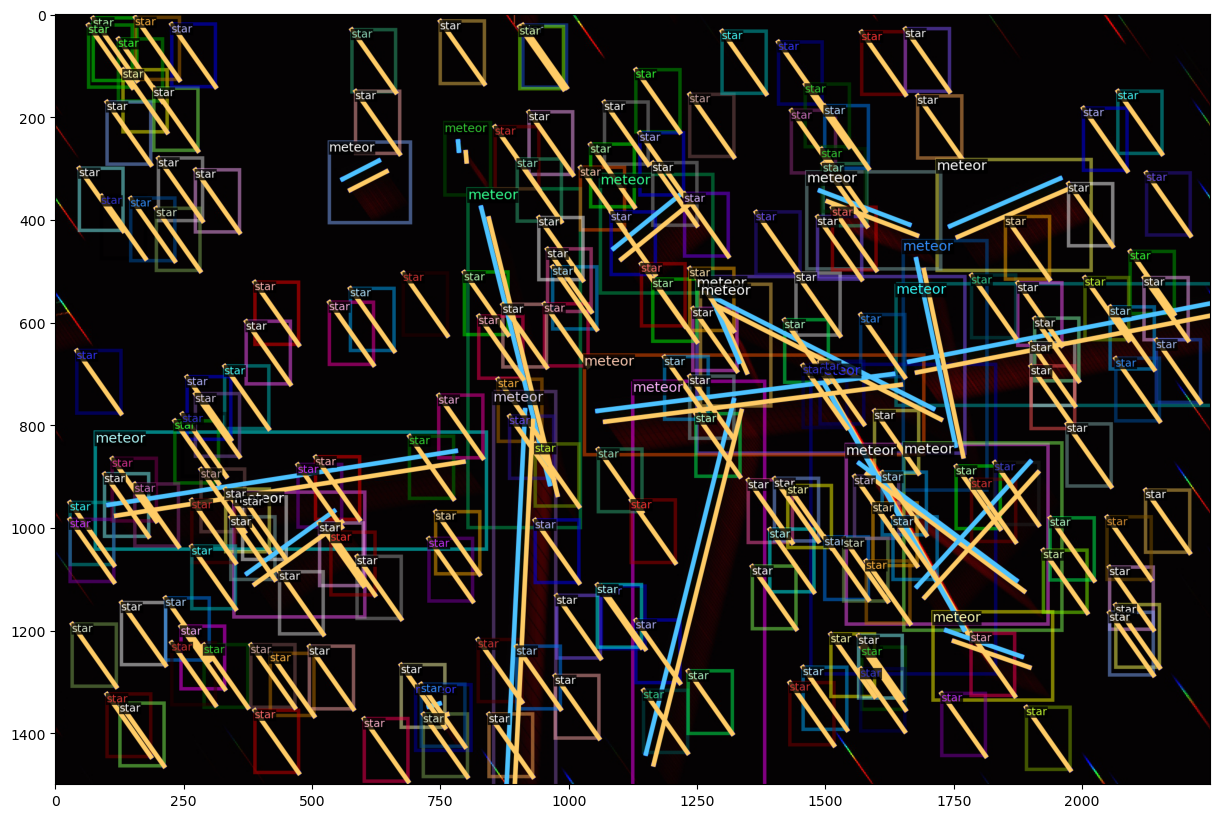

In [25]:

dataset_dicts = DatasetCatalog.get('fake_meteors')
metadata = MetadataCatalog.get('fake_meteors')

for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])


## Train

Using `R50-FPN 3x` model in `COCO Person Keypoint Detection Baselines with Keypoint R-CNN` 

In [30]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg

out_dir = './output/'
os.makedirs(out_dir, exist_ok=True)

cfg = get_cfg()
cfg.OUTPUT_DIR = out_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fake_meteors",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

print('Training head')

cfg.MODEL.BACKBONE.FREEZE_AT = 4   # Initial re-training of the head layers (i.e. freeze the backbone)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []          # do not decay learning rate for retraining head layers
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# print('Training full model')

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.MAX_ITER = 7000          # for LR scheduling
cfg.SOLVER.BASE_LR = 0.0001   
cfg.SOLVER.STEPS = [0,6999]        # decay learning rate
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.MODEL.WEIGHTS = os.path.join(out_dir, 'model_final.pth')  # Initialize from a local weights
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

print('Saving loss')

# np.save(out_dir+'_losses',trainer.lossList)
# np.save(out_dir+'_val_losses',trainer.vallossList)




Training head
[02/10 21:17:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
    

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/10 21:17:49 d2.engine.train_loop]: Starting training from iteration 0


/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/10 21:17:55 d2.utils.events]:  eta: 0:13:39  iter: 19  total_loss: 9.089  loss_cls: 0.6607  loss_box_reg: 0.4304  loss_keypoint: 7.148  loss_rpn_cls: 0.466  loss_rpn_loc: 0.3232  time: 0.2730  data_time: 0.1213  lr: 0.001  max_mem: 6328M
[02/10 21:18:00 d2.utils.events]:  eta: 0:13:16  iter: 39  total_loss: 7.937  loss_cls: 0.556  loss_box_reg: 0.4428  loss_keypoint: 6.396  loss_rpn_cls: 0.1772  loss_rpn_loc: 0.3295  time: 0.2701  data_time: 0.1081  lr: 0.001  max_mem: 6328M
[02/10 21:18:05 d2.utils.events]:  eta: 0:13:07  iter: 59  total_loss: 8.369  loss_cls: 0.5235  loss_box_reg: 0.3877  loss_keypoint: 6.873  loss_rpn_cls: 0.1672  loss_rpn_loc: 0.3796  time: 0.2668  data_time: 0.0989  lr: 0.001  max_mem: 6328M
[02/10 21:18:10 d2.utils.events]:  eta: 0:12:59  iter: 79  total_loss: 8.598  loss_cls: 0.5148  loss_box_reg: 0.5111  loss_keypoint: 7.107  loss_rpn_cls: 0.1488  loss_rpn_loc: 0.3095  time: 0.2644  data_time: 0.0952  lr: 0.001  max_mem: 6328M
[02/10 21:18:16 d2.utils.event

/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/10 21:32:04 d2.utils.events]:  eta: 0:29:45  iter: 19  total_loss: 7.243  loss_cls: 0.1611  loss_box_reg: 0.1935  loss_keypoint: 6.528  loss_rpn_cls: 0.1133  loss_rpn_loc: 0.1474  time: 0.2621  data_time: 0.0581  lr: 0.0001  max_mem: 6328M
[02/10 21:32:09 d2.utils.events]:  eta: 0:30:35  iter: 39  total_loss: 7.213  loss_cls: 0.2092  loss_box_reg: 0.1912  loss_keypoint: 6.558  loss_rpn_cls: 0.1067  loss_rpn_loc: 0.1713  time: 0.2619  data_time: 0.0436  lr: 0.0001  max_mem: 6328M
[02/10 21:32:15 d2.utils.events]:  eta: 0:30:36  iter: 59  total_loss: 7.272  loss_cls: 0.1366  loss_box_reg: 0.1693  loss_keypoint: 6.736  loss_rpn_cls: 0.09414  loss_rpn_loc: 0.1616  time: 0.2654  data_time: 0.0478  lr: 0.0001  max_mem: 6328M
[02/10 21:32:20 d2.utils.events]:  eta: 0:30:42  iter: 79  total_loss: 6.905  loss_cls: 0.123  loss_box_reg: 0.1649  loss_keypoint: 6.341  loss_rpn_cls: 0.1037  loss_rpn_loc: 0.1213  time: 0.2675  data_time: 0.0505  lr: 0.0001  max_mem: 6328M
[02/10 21:32:26 d2.utils

[02/10 22:27:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Instances(num_instances=100, image_height=1000, image_width=1500, fields=[pred_boxes: Boxes(tensor([[ 480.8723,  312.5239,  574.9440,  334.0945],
        [ 149.7805,  809.8984,  246.5005,  832.0450],
        [ 920.1942,  909.1208, 1010.1869,  931.2557],
        [ 847.8467,   95.1049,  937.6805,  115.9541],
        [ 539.7032,  909.9863,  636.1901,  932.5156],
        [ 875.1293,  380.0511,  969.1131,  402.4848],
        [1328.0195,  774.2111, 1419.7645,  795.6678],
        [1277.3148,  935.1868, 1366.6212,  957.0394],
        [ 259.0097,   80.2506,  352.7834,  103.1002],
        [ 848.9998,  679.7601,  945.6477,  703.4943],
        [ 694.9847,  264.7252,  785.5123,  287.1668],
        [ 696.8420,   64.1479,  790.0229,   85.5626],
        [ 677.3615,  650.0006,  771.1438,  672.0261],
        [ 695.6738,  679.9464,  784.6731,  700.6317],
        [ 640.1033,   99.9019,  731.1064,  121.9379],
        [1346.8540,  730.3574, 1433.2412,  751.4129],
        [  58.5650,  312.4146,  154.4956,  3

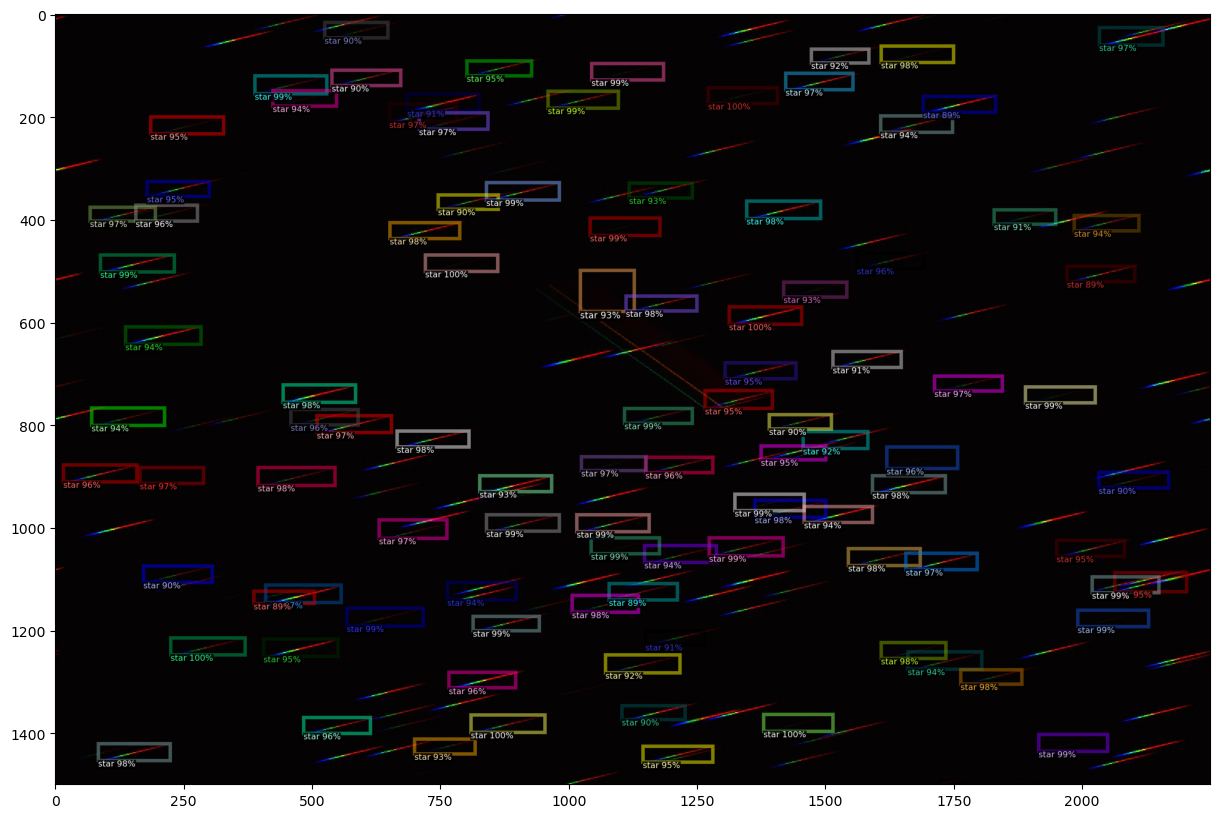

In [83]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0

# for d in random.sample(dataset_dicts, 1):    
im = plt.imread(d["file_name"])
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], metadata, scale=1.5)
print(outputs["instances"])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

# Evaluation

See how it works in our validation dataset (TODO) and the real image

Reference of the real image: `2021JIMO...49...71Z`

[02/10 22:47:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


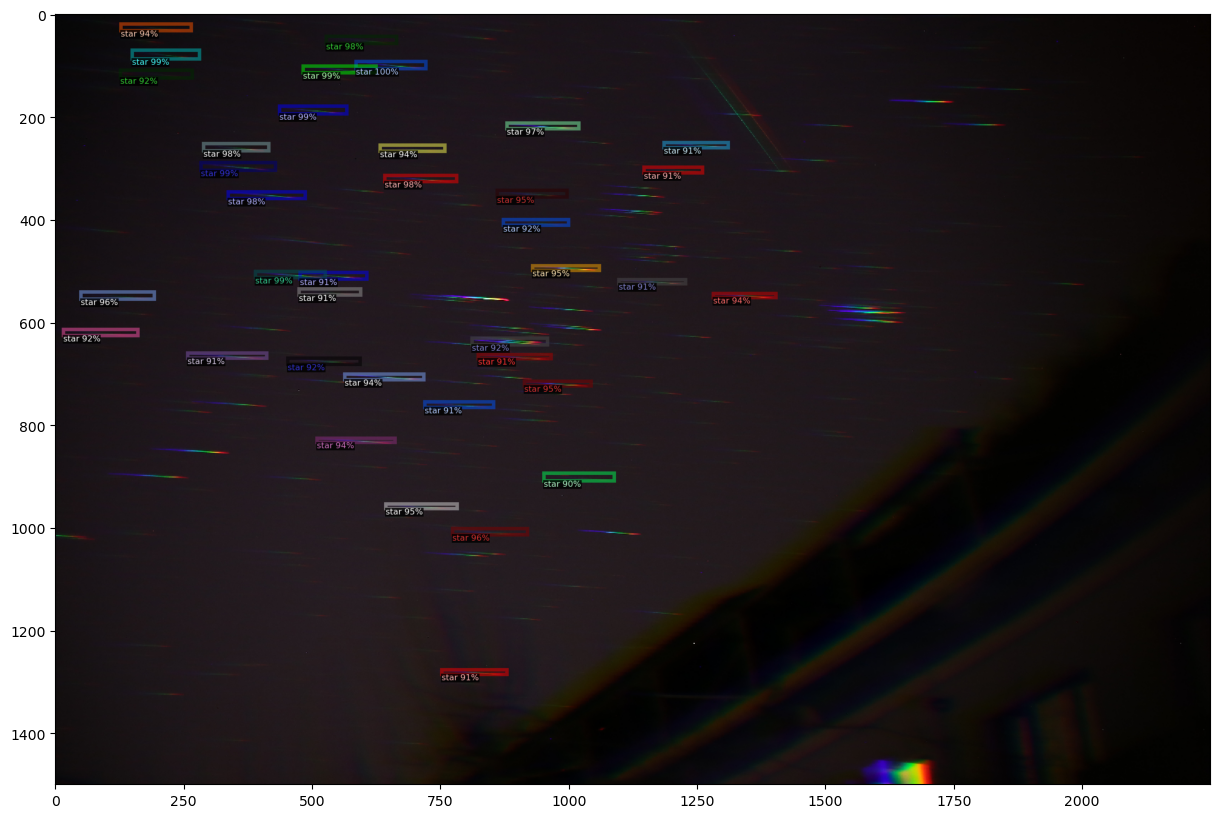

In [93]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9

del MetadataCatalog.get("fake_meteors").keypoint_names
MetadataCatalog.get("fake_meteors").keypoint_names = ['1', '2', '3', '4']

im = plt.imread("testimg2.jpg")
im = cv2.resize(im, dsize=(1500, 1000), interpolation=cv2.INTER_CUBIC)
# print(im.shape, im.dtype)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
# print(outputs["instances"])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

In [61]:
# import rawpy

# path = '../01/IMG_0241.CR2'
# with rawpy.imread(path) as raw:
# #     rgb = raw.postprocess(output_bps=16)
#     rgb_show = raw.postprocess(output_bps=8)

img = plt.imread('testimg.jpg')

img = cv2.resize(img, dsize=(1500, 1000), interpolation=cv2.INTER_CUBIC)

# plt.figure(figsize=[15, 10])
# plt.imshow(img, cmap=plt.cm.gray)
outputs = predictor(img)
v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


IndexError: list index out of range

In [10]:
metadata

namespace(name='fake_meteors',
          json_file='./dataset/labels.json',
          image_root='./dataset/',
          evaluator_type='coco',
          thing_classes=['meteor', 'star'],
          thing_dataset_id_to_contiguous_id={1: 0, 2: 1},
          keypoint_names=['meteor', 'star'],
          keypoint_flip_map=[])